# MOM Lasso using random blocks

In [28]:
import sys,os

In [29]:
sys.path.append(os.path.abspath('/Users/charleslaroche/Documents/GitHub/Internship-at-CREST/PROCEDURE'))

In [30]:
import nbimporter
import numpy as np
import numpy.random as alea
import random as rd
import matplotlib.pyplot as plt
from math import *
import progressbar
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
import procedure_MOM as PM
from random_data import *
from sklearn.preprocessing import normalize

In [31]:
%matplotlib notebook

In [32]:
iter_max = 200
n = 200
n_outliers = 3
features  =  50
sparsity  =  10
lamb  =  1
K1  =  5
K2  =  7
step_size1  =  0.01
step_size2  =  0.003
sigma  =  1
t_0  =  create_t_0(features,sparsity)
Y1,X1  =  data1(n,t_0,1)
Y1,X1  =  np.matrix(Y1),np.matrix(X1)
Y2,X2  =  data2(n_outliers,features,type_outliers  =  2)
Y2,X2  =  np.matrix(Y2),np.matrix(X2)
Y,X  =  data_merge(Y1, X1, Y2, X2)

### Gradient descent for the classical Lasso

In [6]:
def lasso(X,Y,t_0,iter_max,lamb,step_size) :
    
    n,p = np.shape(X)
    t = np.matrix(np.zeros((p,1)))
    error = [np.linalg.norm(t_0  -  t)]
    L = np.linalg.norm(X) ** 2
    
    for l in range(iter_max) :
        
        #Gradient descent
        t = t - step_size * PM.subgrad(X,Y,t,lamb) / np.sqrt(l + 1)  
        
        error.append(np.linalg.norm(t_0 - t))
        
    return t,error

### MOM Lasso with subgradient descent. 

In [7]:
def subgrad_MOM_lasso(X,Y,t_0,iter_max,K,lamb,step_size) :
    
    n,d = np.shape(X)
    j = n // K
    t,t_prime = np.matrix(np.zeros((d,1))),np.matrix(np.zeros((d,1)))
    error = [np.linalg.norm(t_0 - t)]
    
    for l in range(iter_max) :
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        t = t - step_size * PM.subgrad(Xk,Yk,t,lamb) / np.sqrt(l + 1)  
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        t_prime = t_prime - step_size * PM.subgrad(Xk,Yk,t_prime,lamb) / np.sqrt(l + 1) 
        
        error.append(np.linalg.norm(t_0 - t))
        
    return (t,t_prime),error

### Descente de gradient proximale

In [10]:
def ISTA_lasso(X,Y,t_0,iter_max,K,lamb) :
    
    print(type(X) , type(Y))
    
    n,p = np.shape(X)
    j = n // K
    t,t_prime = np.zeros((p,1)), np.zeros((p,1))
    error = [np.linalg.norm(t_0 - t)]
    
    for l in range(iter_max) :
        
        #block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1]
        tabl = np.square(Y - X @ t ) - np.square(Y - X @ t_prime )
        Xk = X[k]
        Yk = Y[k]
        
        L =  np.linalg.norm(Xk)  **  2  
        t = PM.soft_thresholding(lamb / L , t - (1 / L) * PM.grad(Xk,Yk,t))
        
        #block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        L =  np.linalg.norm(Xk)  **  2
        t_prime = PM.soft_thresholding(lamb / L,t_prime - (1 / L) * PM.grad(Xk,Yk,t_prime)) 
        
        error.append(np.linalg.norm(t_0 - t))
        
    return (t,t_prime),error

<class 'numpy.matrixlib.defmatrix.matrix'> <class 'numpy.matrixlib.defmatrix.matrix'>


<IPython.core.display.Javascript object>


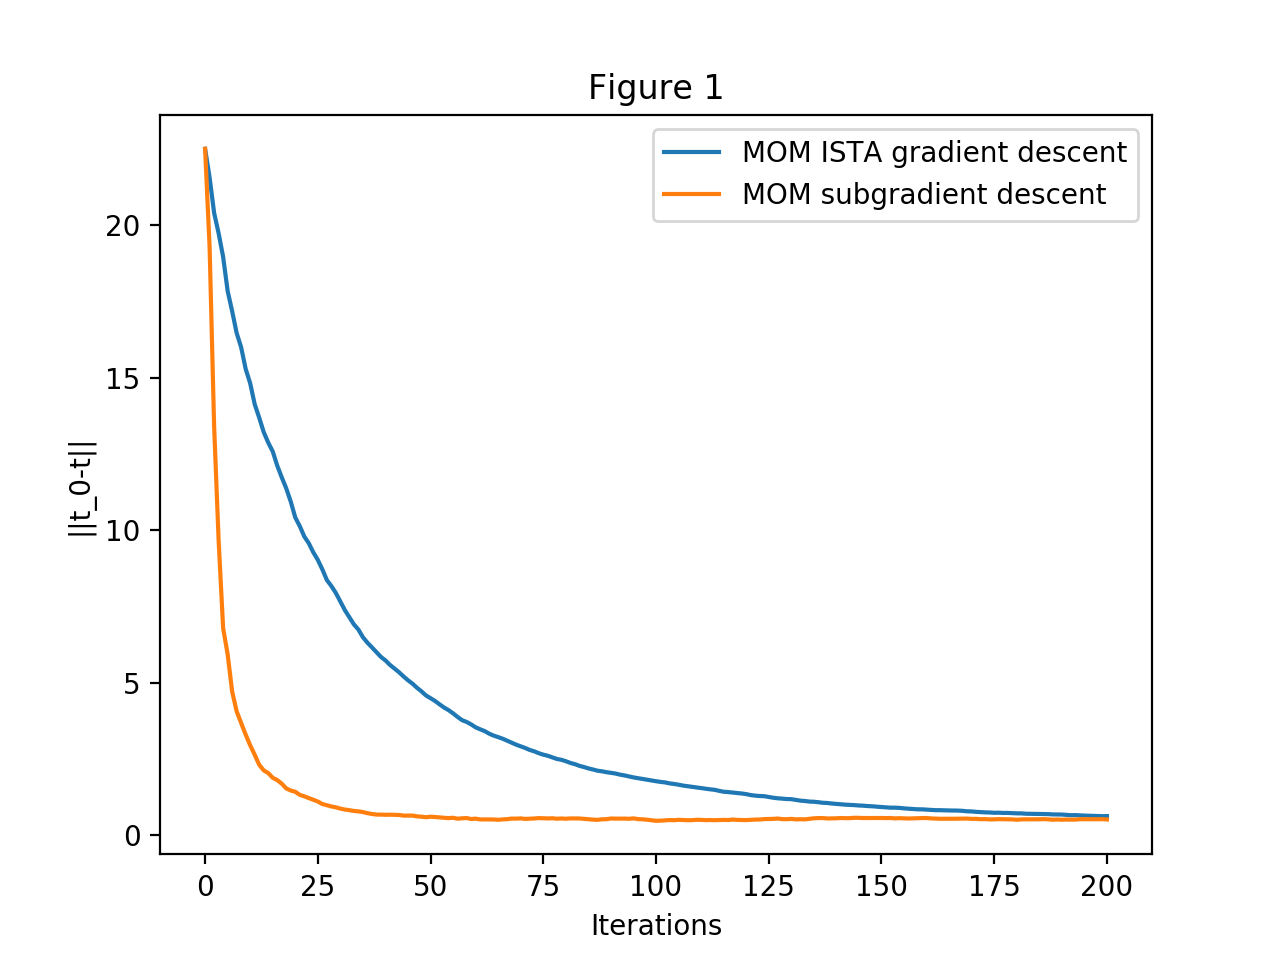

In [11]:
R = ISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM ISTA gradient descent")
R = subgrad_MOM_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.009)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM subgradient descent")
plt.xlabel("Iterations")
plt.ylabel("||t_0-t||")
plt.title("Figure 1")
plt.legend()
plt.show()

In [12]:
def LS_ISTA_lasso(X,Y,t_0,nmax,K,lamb,mu) :
    n,p = np.shape(X)
    j = n // K
    t,t_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    error = [np.linalg.norm(t_0 - t)]
    
    for l in range(nmax) :
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        #Beginning of backtracking with c = 1/2
        gamma = 1
        t_prev = t
        F = PM.quadra_loss(Xk,Yk,t_prev)
        
        t = PM.soft_thresholding(lamb * gamma,t - gamma * PM.grad(Xk,Yk,t))
        delta = PM.quadra_loss(Xk,Yk,t) - F - PM.grad(Xk,Yk,t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
        
        while delta > 1e-3 :
            
            gamma *= mu
            t = PM.soft_thresholding(lamb * gamma,t_prev - gamma * PM.grad(Xk,Yk,t_prev))
            delta = PM.quadra_loss(Xk,Yk,t) - F - PM.grad(Xk,Yk,t_prev).T * (t - t_prev) - (1 / (2 * gamma))*np.linalg.norm(t - t_prev) ** 2
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        #Beginning of backtracking with c = 1/2
        gamma = 1
        t_prev = t_prime
        F = F = PM.quadra_loss(Xk,Yk,t_prev)
        
        t_prime = PM.soft_thresholding(lamb * gamma,t_prime - gamma * PM.grad(Xk,Yk,t_prime))
        delta = PM.quadra_loss(Xk,Yk,t_prime) - F - PM.grad(Xk,Yk,t_prev).T * (t_prime - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t_prime - t_prev) ** 2
        
        while delta > 1e-3 :
            gamma *= mu
            t_prime = PM.soft_thresholding(lamb * gamma,t_prev - gamma * PM.grad(Xk,Yk,t_prev))
            delta = PM.quadra_loss(Xk,Yk,t_prime) - F - PM.grad(Xk,Yk,t_prev).T * (t_prime - t_prev) - (1 / (2 * gamma))*np.linalg.norm(t_prime - t_prev) ** 2
        
        error.append(np.linalg.norm(t_0 - t))
        
    return (t,t_prime),error

<IPython.core.display.Javascript object>


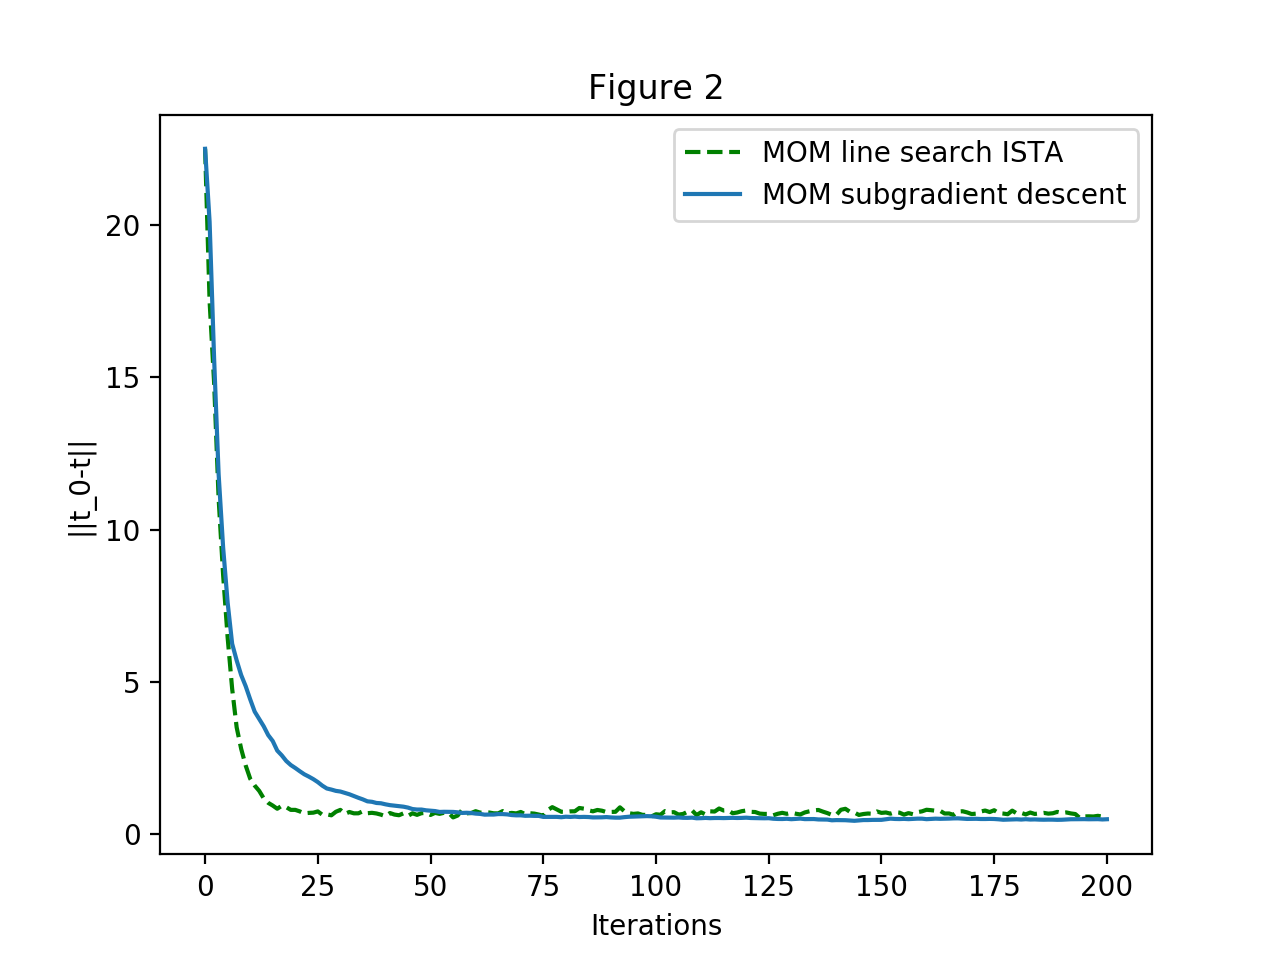

In [13]:
R = LS_ISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb,1/1.2)
plt.plot(np.array([i for i in range(201)]),np.array(R[1]),'g--',label = "MOM line search ISTA")
R = subgrad_MOM_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.009)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM subgradient descent")
plt.ylabel("||t_0-t||")
plt.xlabel("Iterations")
plt.title("Figure 2")
plt.legend()
plt.show()

### ADMM

In [14]:
def ADMM_lasso(X,Y,t_0,nmax,K,lamb,rho) :
    
    n,p = np.shape(X)
    t,t_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    z,z_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    u,u_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    j = n // K
    error = [np.linalg.norm(t_0 - t)]
    rhoM = rho * np.identity(p)
    
    for l in range(nmax) :
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        t = np.linalg.solve((Xk.T) * Xk  +  rhoM, (Xk.T) * Yk  +  rho * z  -  u)
        z = PM.soft_thresholding(lamb / rho,t + u / rho)
        u = u + rho * (t - z)
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        t_prime = np.linalg.solve((Xk.T) * Xk  +  rhoM, Xk.T * Yk  +  rho * z_prime  -  u_prime)
        z_prime = PM.soft_thresholding(lamb / rho,t_prime + u_prime / rho)
        u_prime = u_prime + rho * (t_prime - z_prime)
        
        error.append(np.linalg.norm(t_0 - t))
        
    return (t,t_prime),error

<IPython.core.display.Javascript object>


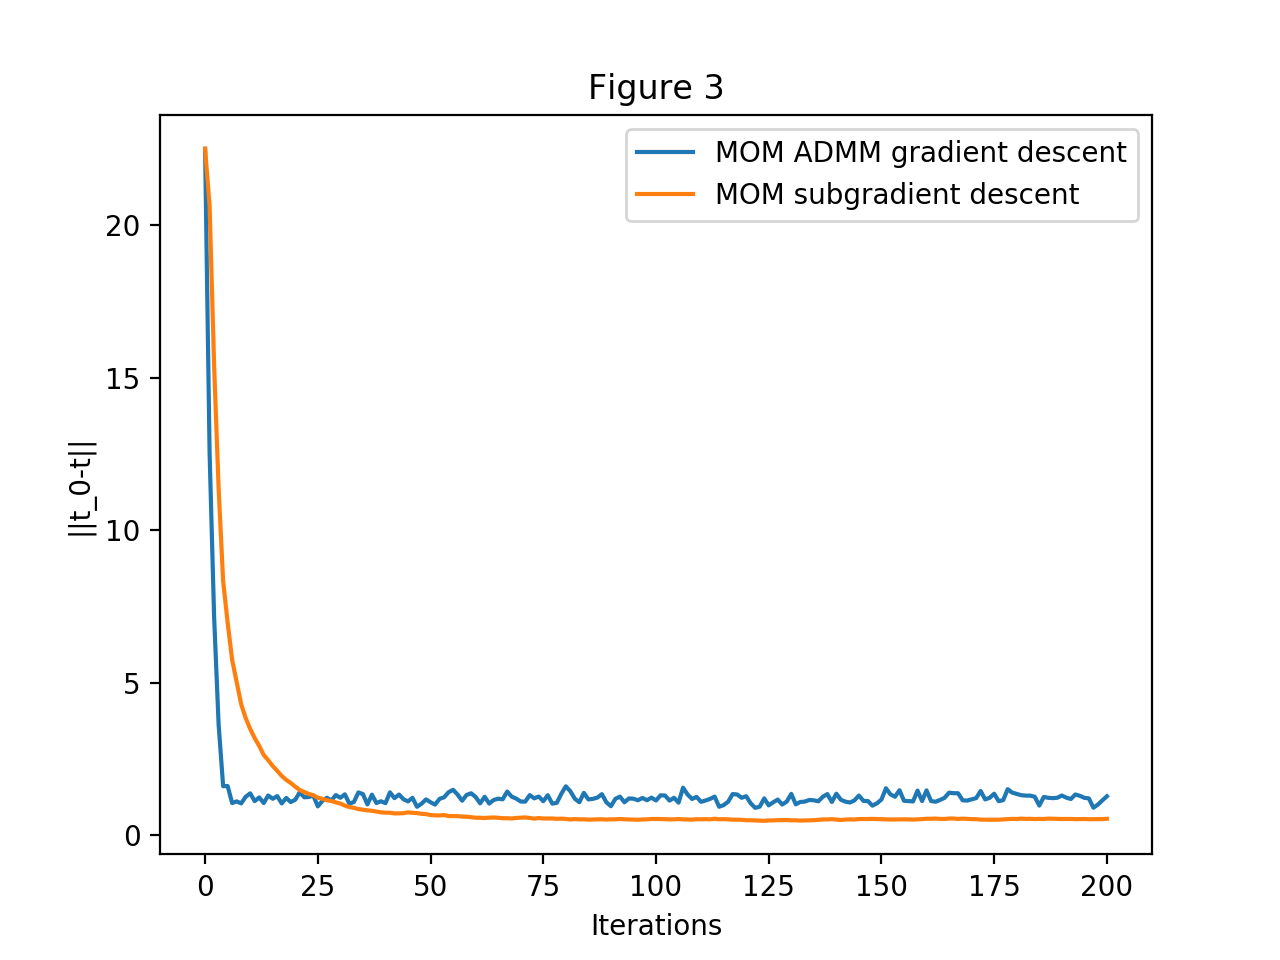

In [15]:
R = ADMM_lasso(X1,Y1,t_0,iter_max,K1,lamb,5)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM ADMM gradient descent")
R = subgrad_MOM_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.009)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM subgradient descent")
plt.ylabel("||t_0-t||")
plt.xlabel("Iterations")
plt.title("Figure 3")
plt.legend()
plt.show()

### MOM Lasso with FISTA gradient descent

In [16]:
def FISTA_lasso(X,Y,t_0,nmax,K,lamb) :
    
    n,p = np.shape(X)
    j = n // K
    t,t_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    z,z_prime = t,t_prime
    error = [np.linalg.norm(t_0 - t)]
    
    for l in range(nmax) :
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1]
        Xk = X[k]
        Yk = Y[k]
        
        L =  np.linalg.norm(Xk)  **  2  
        t_prev = t
        t = PM.soft_thresholding((lamb / L),z - (1 / L) * PM.grad(Xk,Yk,z)) 
        z = t + (l / (l + 3)) * (t - t_prev)
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] #
        Xk = X[k]
        Yk = Y[k]
        
        L =  np.linalg.norm(Xk)  **  2
        t_prev = t_prime
        t_prime = PM.soft_thresholding((lamb / L),z_prime - (1 / L) * PM.grad(Xk,Yk,z_prime)) 
        z_prime = t_prime + (l / (l + 3)) * (t_prime - t_prev) 
        
        error.append(np.linalg.norm(t_0 - t))
        
    return (t,t_prime),error
    

In [17]:
def LS_FISTA_lasso(X,Y,t_0,nmax,K,lamb,mu) :
    
    n,p = np.shape(X)
    j = n // K
    t,t_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    z,z_prime = t,t_prime
    error = [np.linalg.norm(t_0 - t)]
    
    for l in range(nmax) :
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        
        #Beginning of backtracking with c = 1/2
        gamma = 1
        t_prev = t
        F = PM.quadra_loss(Xk,Yk,t_prev)
        
        t = PM.soft_thresholding(lamb * gamma,z - gamma * PM.grad(Xk,Yk,z))
        delta = PM.quadra_loss(Xk,Yk,t) - F - PM.grad(Xk,Yk,t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
        
        while delta > 1e-3 :
            gamma *= mu
            t = PM.soft_thresholding(lamb * gamma,z - gamma * PM.grad(Xk,Yk,z))
            delta = PM.quadra_loss(Xk,Yk,t) - F - PM.grad(Xk,Yk,t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
            

        z = t + (l / (l + 3)) * (t - t_prev)
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1]
        Xk = X[k]
        Yk = Y[k]
        
        #Beginning of backtracking with c = 1/2
        gamma = 1
        t_prev = t_prime
        F = PM.quadra_loss(Xk,Yk,t_prev)
        
        t_prime = PM.soft_thresholding(lamb * gamma,z_prime - gamma * PM.grad(Xk,Yk,z_prime))
        delta = PM.quadra_loss(Xk,Yk,t_prime) - F - PM.grad(Xk,Yk,t_prev).T * (t_prime - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t_prime - t_prev) ** 2
        
        while delta > 1e-3 :
            
            gamma *= mu
            t_prime = PM.soft_thresholding(lamb * gamma,z_prime - gamma * PM.grad(Xk,Yk,z_prime))
            delta = PM.quadra_loss(Xk,Yk,t_prime) - F - PM.grad(Xk,Yk,t_prev).T * (t_prime - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t_prime - t_prev) ** 2

        z_prime = t_prime + (l / (l + 3)) * (t_prime - t_prev) 
        
        error.append(np.linalg.norm(t_0 - t))
        
    return (t,t_prime),error

<IPython.core.display.Javascript object>


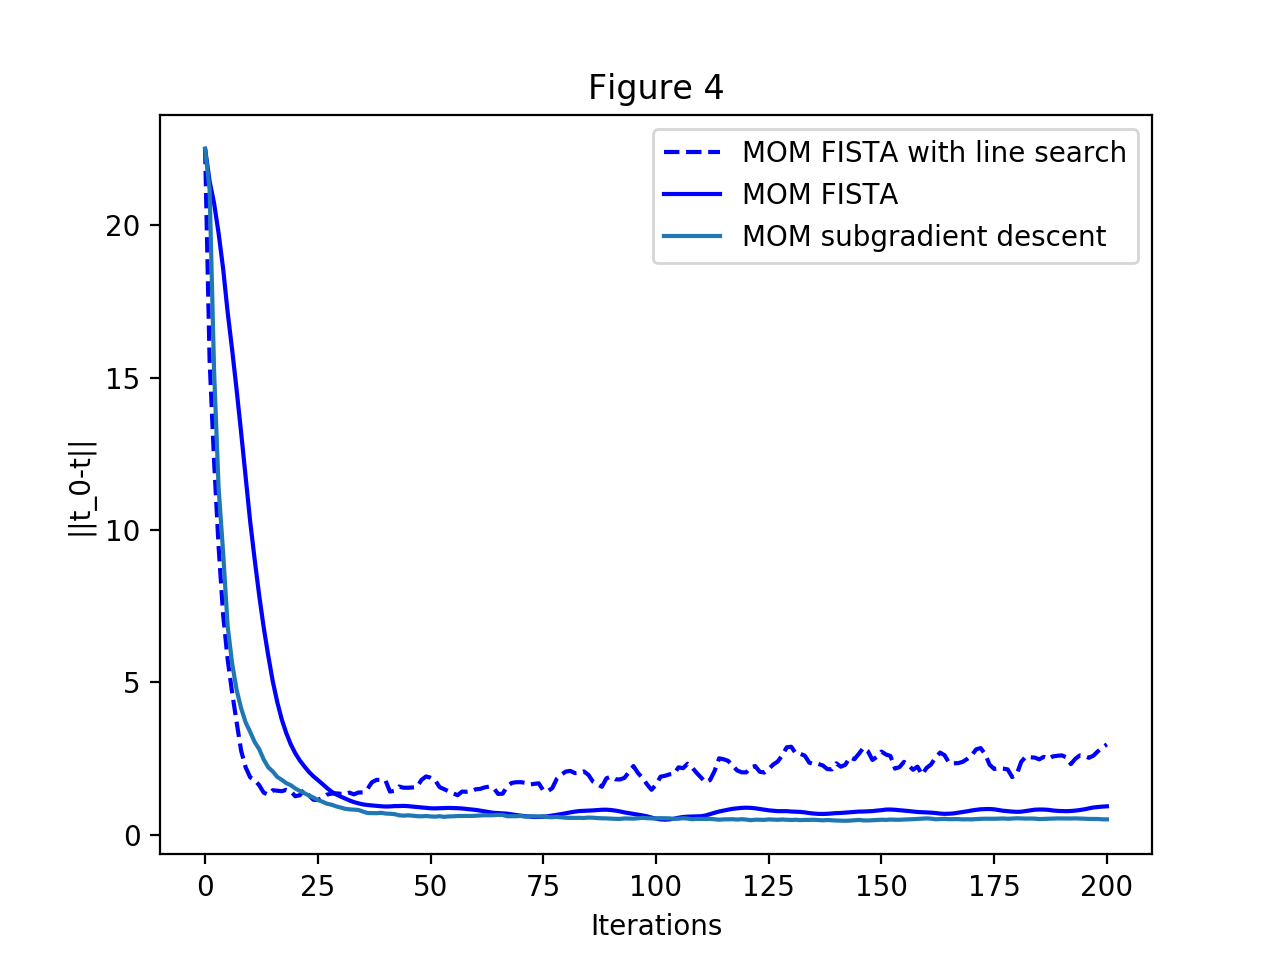

In [19]:
%matplotlib notebook
R = LS_FISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.5)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),'b--',label = "MOM FISTA with line search")
R = FISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),'b',label = "MOM FISTA")
R = subgrad_MOM_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.009)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM subgradient descent")
plt.ylabel("||t_0-t||")
plt.xlabel("Iterations")
plt.title("Figure 4")
plt.legend()
plt.show()

### Performances

<IPython.core.display.Javascript object>


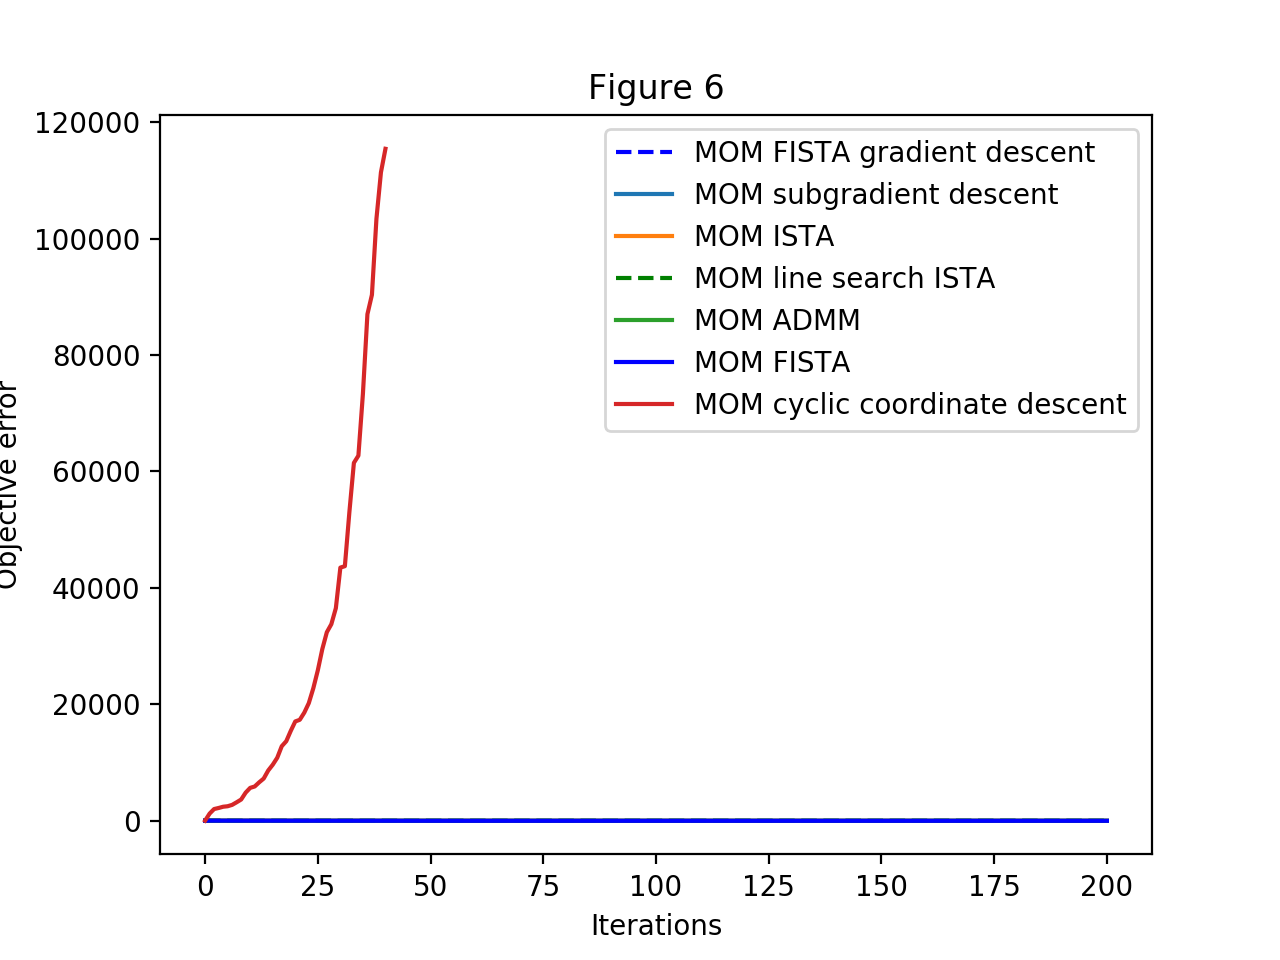

<class 'numpy.matrixlib.defmatrix.matrix'> <class 'numpy.matrixlib.defmatrix.matrix'>


In [20]:
%matplotlib notebook
R = LS_FISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.5)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),'b--',label = "MOM FISTA gradient descent")
R = subgrad_MOM_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.009)
plt.plot(np.array([i for i in range(201)]),np.array(R[1]),label = "MOM subgradient descent")
R = ISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM ISTA")
R = LS_ISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb,0.5)
plt.plot(np.array([i for i in range(201)]),np.array(R[1]),'g--',label = "MOM line search ISTA")
R = ADMM_lasso(X1,Y1,t_0,iter_max,K1,lamb,5)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "MOM ADMM")
#R = lasso(X1,Y1,t_0,iter_max,lamb,0.003)
#plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),label = "Gradient descent")
R = FISTA_lasso(X1,Y1,t_0,iter_max,K1,lamb)
plt.plot(np.array([i for i in range(iter_max + 1)]),np.array(R[1]),'b',label = "MOM FISTA")
plt.ylabel("||t_0-t||")
plt.xlabel("Iterations")
plt.legend()
plt.title("Figure 5")
plt.show()

### Descente coordonnées cycliques

In [86]:
def effi_cycl_lasso(X,Y,t_0,iter_max,K,lamb) :
    
    n,d = np.shape(X)
    t,t_prime = np.matrix(np.zeros((d,1))) , np.matrix(np.zeros((d,1)))
    j = n // K
    error = [np.linalg.norm(t_0 - t)]
    
    for l in range(iter_max) :
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1]
        Xk = normalize(X[k])
        Yk = normalize(Y[k])
        
        for i in range(d) :
            
            s = np.expand_dims(PM.som(t , Xk , 1 , d) , -1)
            Rk = (Xk.T)[i].reshape((1,j)) @ (Yk - s)
            t[i][0] = Rk * PM.part_pos(1 - lamb / (2 * abs(Rk))) / (np.linalg.norm(Xk[ :,i]) ** 2)
            
            if i != (d - 1) :
                s = s - int(t[i + 1][0]) * Xk[ :,i + 1] + int(t[i][0]) * Xk[ :,i]
                
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = normalize(X[k])
        Yk = normalize(Y[k])
        
        for i in range(d) :
            s = np.expand_dims(PM.som(t_prime , Xk , 1 ,d) , -1)
            s.reshape((len(s),1))
            Rk = (Xk.T)[i].reshape((1,j)) @ (Yk - s)
            t_prime[i][0] = Rk * PM.part_pos(1 - lamb / (2 * abs(Rk))) / (np.linalg.norm(Xk[ :,i]) ** 2)
            
            if i != (d - 1) :
                s = s - int(t_prime[i + 1][0]) * Xk[ :,i + 1] + int(t_prime[i][0]) * Xk[ :,i]
                
        error.append(np.linalg.norm(t_0 - t))
        
    return (t,t_prime),error

<IPython.core.display.Javascript object>


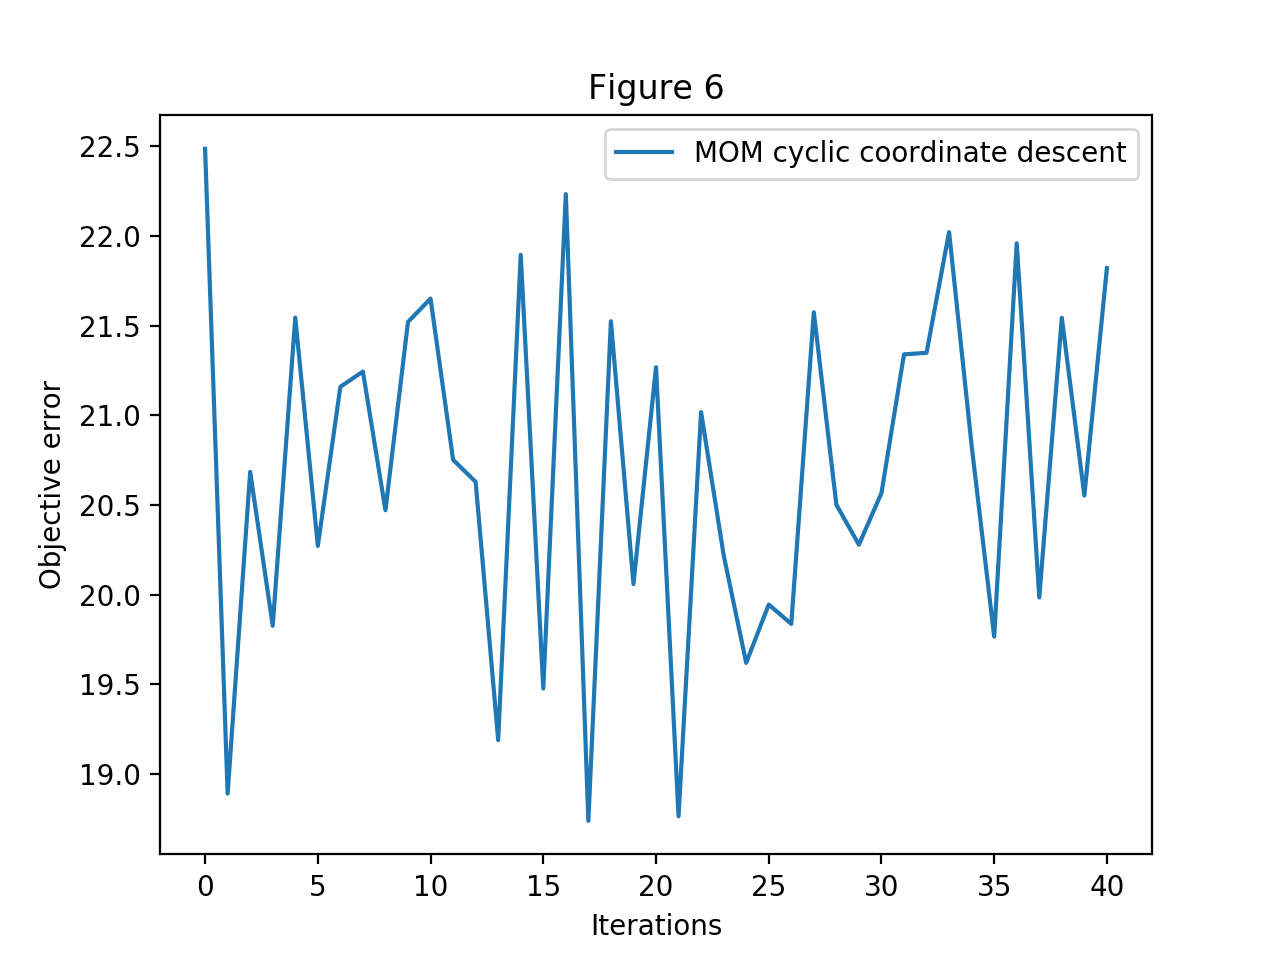

In [87]:
R = effi_cycl_lasso(X1,Y1,t_0,40,4,0.1)
plt.plot(np.array([i for i in range(41)]),np.array(R[1]),label = "MOM cyclic coordinate descent")
plt.xlabel("Iterations")
plt.ylabel("Objective error")
plt.title("Figure 6")
plt.legend()
plt.show()

### MOM cross validation V - Fold

In [22]:
def cross_validation_Vfold(V,X,Y,nb_test,lamb_0,lamb_max) :
    
    global t_0
    
    n,p = np.shape(X)
    n_prime = n // V
    t_0 = np.zeros((p,1))
    D = PM.diviseurs(n_prime)
    nb_K = len(D)
    error_tab = np.zeros((nb_test,nb_K))
    bar  =  progressbar.ProgressBar()
    pas = (lamb_max - lamb_0)/nb_test
    
    for i in bar(range(nb_test)) :
        
        lamb = lamb_0 + pas * i
        
        j = 0
        
        for K in D :
            
            error = 0
            l = []
            
            for k in range(V) :
                
                XV_train = np.concatenate((X[ : k * n_prime] , X[(k + 1) * n_prime :]))  
                YV_train = np.concatenate((Y[ : k*n_prime] , Y[(k + 1) * n_prime :]))  
                XV_test = X[k * n_prime : (k + 1) * n_prime]
                YV_test = Y[k * n_prime : (k + 1) * n_prime]
                
                t1,_ = ADMM_lasso(XV_train,YV_train,t_0,50,K,lamb,5)[0]
                
                l.append(PM.MOM(PM.P_quadra(XV_test,YV_test,t1),K)[0]) #l[k] = MOM_K(Pb1(k),..,pbK(k))
                
            error_tab[i][j] = PM.median(l)[0]
            
            j += 1
            
    return error_tab
    

In [26]:
n = 198
n_outliers = 2
features = 50
sparsity = 10
sigma = 1
V = 5

t_0 = create_t_0(features,sparsity)
Y1,X1 = data1(n,t_0,sigma)
Y1,X1 = np.matrix(Y1),np.matrix(X1)
Y2,X2 = data2(n_outliers,features,type_outliers = 2)
Y2,X2 = np.matrix(Y2),np.matrix(X2)
Y,X = data_merge(Y1, X1, Y2, X2)

In [27]:
err = cross_validation_Vfold(V,X,Y,25,0.1,1)

NameError: name 'cross_validation_Vfold' is not defined

<IPython.core.display.Javascript object>


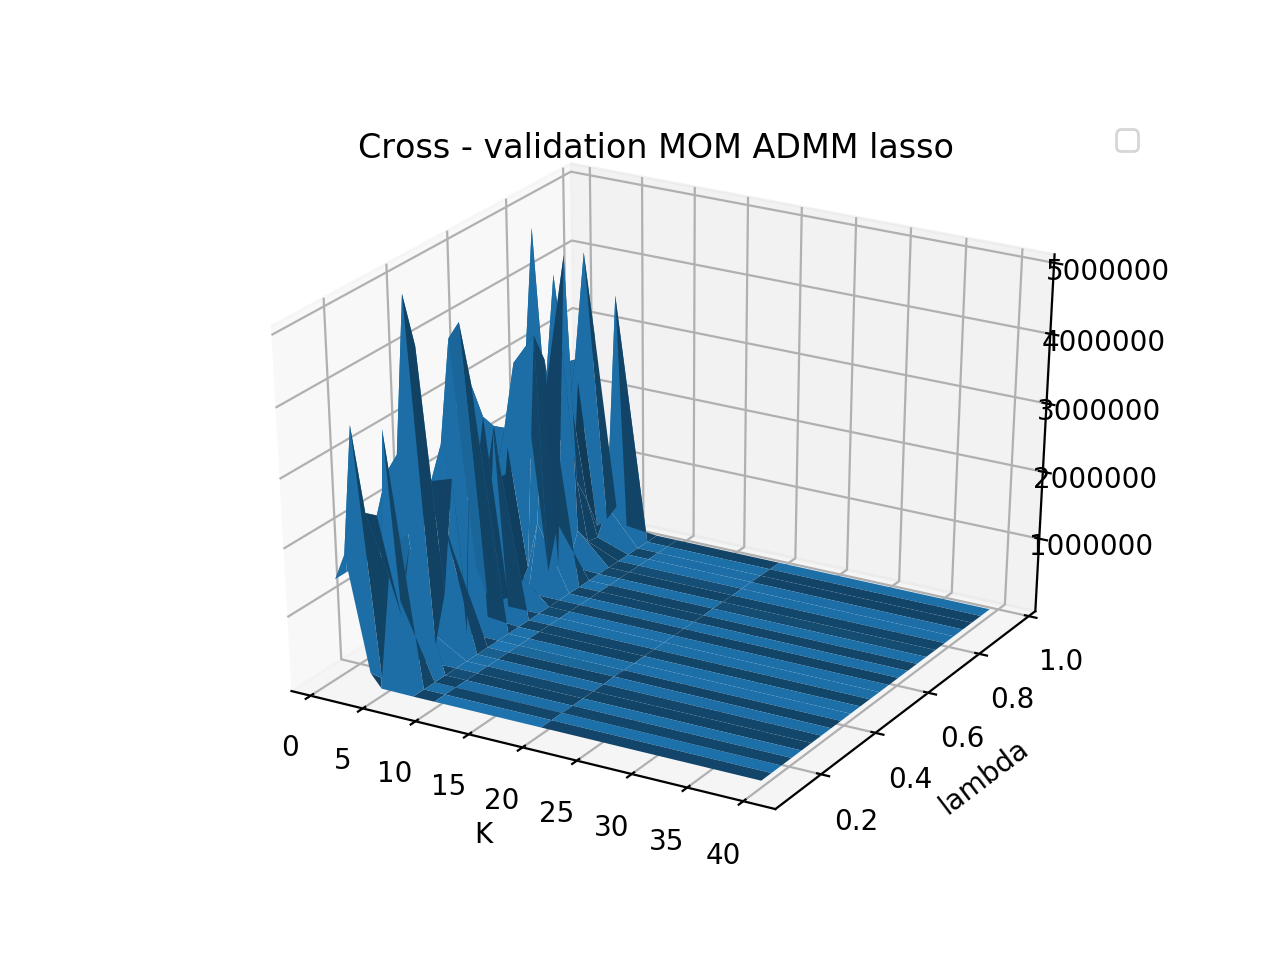

No handles with labels found to put in legend.


(25, 8)


In [25]:
n,p = np.shape(err)
D = PM.diviseurs(40)
fig  =  plt.figure()
ax  =  fig.gca(projection = '3d')
pas = (1 - 0.1) / 25
Y1 = np.array([0.1 + pas*i for i in range(n)])
X1 = np.array(D)
X1,Y1 = np.meshgrid(X1,Y1)
print(np.shape(Y1))
surf = ax.plot_surface(X1,Y1,err)
plt.xlabel("K")
plt.ylabel("lambda")
plt.title("Cross - validation MOM ADMM lasso")
plt.legend()
plt.show()

In [26]:
def best_hyp(err,D,lamb_0,lamb_max) :
    
    n,p = np.shape(err)
    pas = (lamb_max - lamb_0) / n
    i,j = np.argmin(err)
    
    print("Lambda = ",lamb_0 + i * pas)
    print("K = ",D[j])
    
    return (lamb_0 + i * pas , D[j])
    

In [27]:
best_hyp(err,D,0.1,1)

Lambda =  0.352
K =  8


(0.352, 8)

L'argmin nous indique que les hyperparamètres optimaux sont K = 8  et lambda = 0.352 pour l'algorithme ADMM

In [28]:
def outliers_detection(X,Y,K,lamb,rho,nmax) :
    
    n,p = np.shape(X)
    j = n // K
    rhoM = rho * np.identity(p)
    t,t_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    z,z_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    u,u_prime = np.matrix(np.zeros((p,1))),np.matrix(np.zeros((p,1)))
    
    hist = np.zeros(0)
    
    for l in range(nmax) :
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        t = np.linalg.solve((Xk.T) * Xk  +  rhoM, (Xk.T) * Yk  +  rho * z  -  u)
        z = PM.soft_thresholding(lamb / rho,t + u / rho)
        u = u + rho * (t - z)
        
        hist = np.concatenate((hist,k))
        
        #Block detection
        k = PM.MOM(PM.lt_lt_prime(X,Y,t,t_prime),K)[1] 
        Xk = X[k]
        Yk = Y[k]
        
        t_prime = np.linalg.solve((Xk.T) * Xk  +  rhoM, Xk.T * Yk  +  rho * z_prime  -  u_prime)
        z_prime = PM.soft_thresholding(lamb / rho,t_prime + u_prime / rho)
        u_prime = u_prime + rho * (t_prime - z_prime) 
        
        hist = np.concatenate((hist,k))
        
    return (t,t_prime),hist

<IPython.core.display.Javascript object>


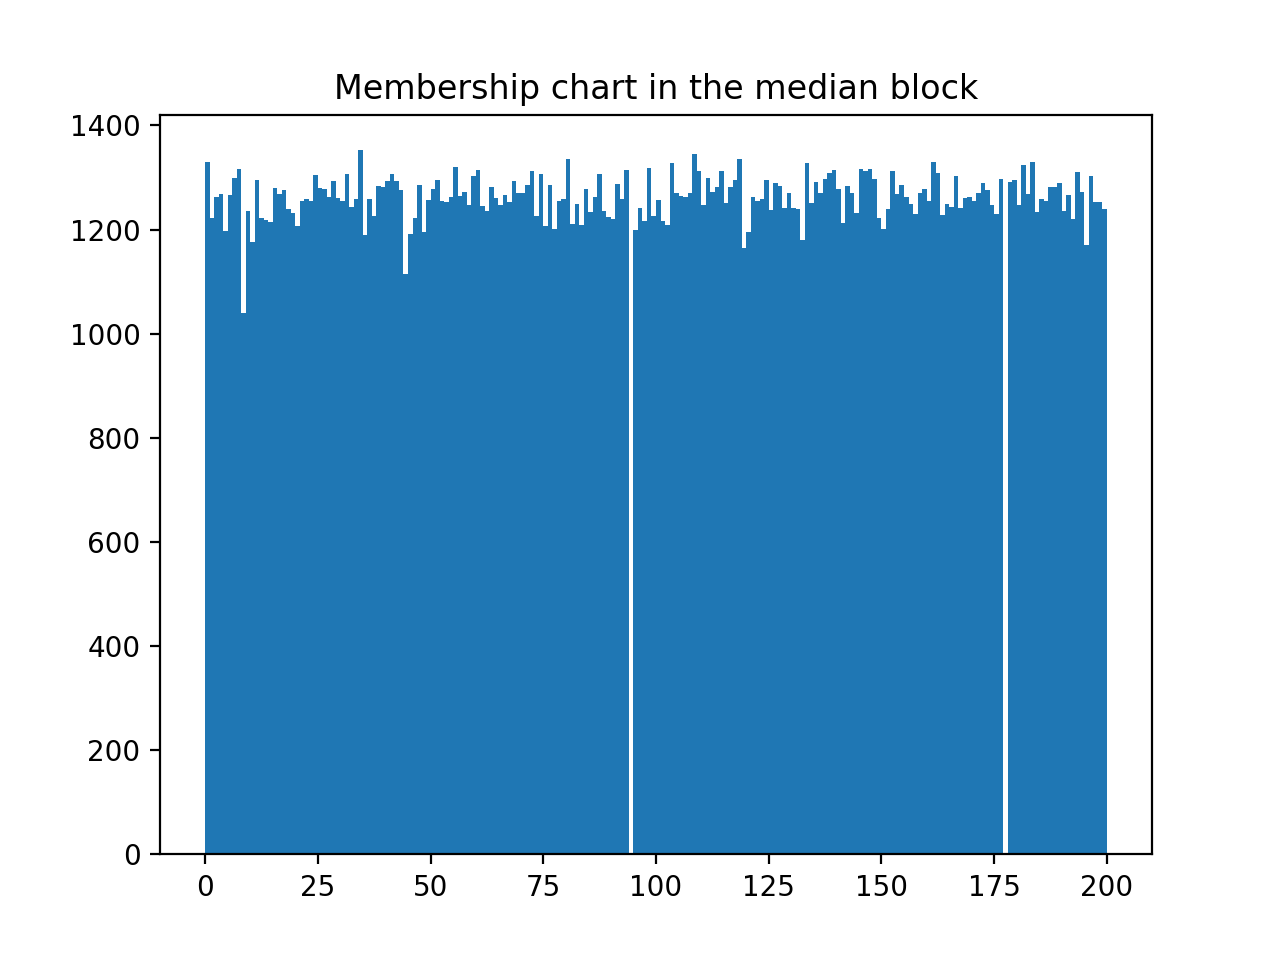

In [29]:
%matplotlib notebook
plt.hist(outliers_detection(X,Y,8,0.352,5,5000)[1],bins = [i for i in range(201)])
plt.title("Membership chart in the median block")
plt.show()